In [ ]:
# Active learning to determine optimal compositions of a cell-free reaction
# Data can come from plate reader/microfluidics experiments
# or be generated in-silico for demonstration purposes

# The in silico model is a genome-scale metabolic model from Horvath et al. 2020
# paper: https://doi.org/10.1016/j.mec.2019.e00113
# github: https://github.com/varnerlab/Kinetic-CFPS-Model-Publication-Code

# The active learning framework is adapted from Borkowski et al. 2020 
# paper: https://doi.org/10.1101/751669.
# github: https://github.com/brsynth/active_learning_cell_free 

# by N. Laohakunakorn (nadanai.laohakunakorn@ed.ac.uk)
# April 2021

In [1]:
using Flux
using Flux.Optimise: update!
using Flux: Chain, Dense, Dropout, @epochs
using CUDA
using Base: @kwdef
using Statistics, LsqFit, DataFrames, CSV, ProgressBars, Serialization
using Plots 
using Sundials
using Random; rng = MersenneTwister(1234);
include("./scripts/AL_helpers.jl");
include("./scripts/AL_solver.jl");

First initialise directories, hyperparameters, and GPU if available.

In [3]:
# Directories
OUTPUT = "./models/" # directory where models are saved
INPUT = "./data/" # directory where compositional/output data are saved

# Hyperparameters
@kwdef mutable struct Args
    η::Float64 = 0.001       # learning rate
    batchsize::Int = 99    # batch size
    epochs::Int = 500     # number of epochs
    use_cuda::Bool = false   # use gpu (if cuda available)
end
args = Args()

# GPU 
if CUDA.functional() && args.use_cuda
    @info "Training on CUDA GPU"
    CUDA.allowscalar(false)
    device = gpu
else
    @info "Training on CPU"
    device = cpu
end

┌ Info: Training on CPU
└ @ Main In[3]:20


cpu (generic function with 1 method)

### 1. Set up allowed compositions, and random initial grid

Here we choose 8 species which correspond to components of the energy solution. Their maximum allowed concentrations are chosen to be 2 times the starting concentrations in the original Varner model. Each species is associated with an index, defined in the model's DataFiles.jl. We generate the initial training grid of 99 compositions, which consists of 'one-hot' and 'one-cold' settings followed by random compositions. The grid generation is such that no compositions ever repeat throughout the entire learning process.

In [5]:
# 1. Set up compositions to vary, and allowed concentrations
NCOMPS = 8
ntp_c_max = 1.5
aa_nglu_c_max = 3.0 
nad_c_max = 2.94
thf_c_max = 1.24
coa_c_max = 1.24
pga_c_max = 4.26
glu_c_max = 340
trna_c_max = 3.2
ALLOWEDCONCS = [0.1, 0.3, 0.5, 1]
maxcomps = [ntp_c_max,aa_nglu_c_max,nad_c_max,thf_c_max,coa_c_max,pga_c_max,glu_c_max,trna_c_max]
speciesidx = [106,118,145,38,10,7,136,99]; # relevent indices, defined in DataFiles.jl

┌ Info: Generating initial grid
└ @ Main In[7]:2


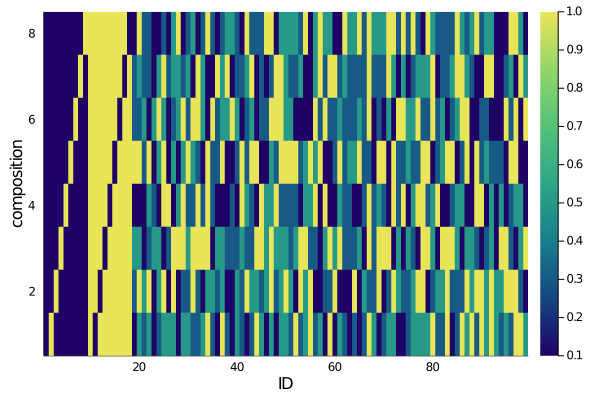

In [7]:
# Generate initial grid, save, and have a look at it
@info "Generating initial grid"
gridsize = 99 # Number of compositions to consider
initialgrid = generate_initial_grid(gridsize,NCOMPS,ALLOWEDCONCS)
CSV.write(INPUT*"initial_grid.csv", DataFrame(initialgrid)); 
heatmap(initialgrid, c=:bluegreenyellow,yaxis="composition",axis="ID")

### 2. Step through one round of active learning

In [9]:
# We step through one round. For 10 rounds, see the script AL_10rounds.jl.
# First define file names.

# Filenames
COMPDATA = ["initial_grid","round1_proposed"]
FLUORDATA = ["round1_fluor"];


#### 1. Read input composition data 

This is the grid we generated earlier.

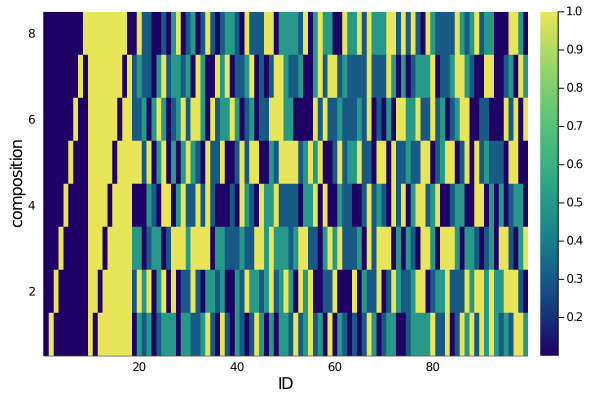

In [14]:
round = 1 # This can be put into a for loop

ROUND = "round"*string(round)
# Read composition data
df = CSV.read(INPUT*COMPDATA[round]*".csv", DataFrame, type=Float32);
x_data = Matrix(df); 
# size(x_data) # should be (8,99)
pl = heatmap(x_data, c=:bluegreenyellow,yaxis="composition",axis="ID")
savefig(OUTPUT*COMPDATA[round]*".pdf")
pl # show plot

#### 2. Generate training data

In [ ]:
# 1. Generate training data for this round
# This takes a long time as all compositions have to be simulated
# Skip to the next cell if you don't want to re-run the simulation,
# as the data is already available

@info "1. Generating training data"
# Solve Varner model for initial composition array
cat_c = []
for j in ProgressBar(1:size(x_data,2))
    compositions = x_data[:,j]
    cat = solvemodel(compositions,maxcomps,speciesidx)
    push!(cat_c,cat)
end
CSV.write(INPUT*FLUORDATA[round]*".csv", DataFrame(reshape(cat_c,(size(x_data,2),1)))); 
df = CSV.read(INPUT*FLUORDATA[round]*".csv", DataFrame, type=Float32);
y_data = reshape(Array(df),gridsize); #/0.018560623281234926 # normalise to original maximum if required
# size(y_data) # should be (99,)
pl = heatmap(reshape(y_data,1,length(y_data)), c=:bluegreenyellow,yaxis="fluorescence",axis="ID")
savefig(OUTPUT*FLUORDATA[round]*".pdf")
pl # show plot

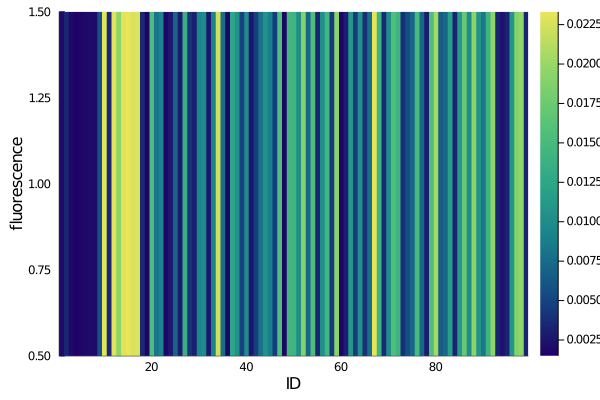

In [16]:
# Read in the data again and look at it
df = CSV.read(INPUT*FLUORDATA[round]*".csv", DataFrame, type=Float32);
y_data = reshape(Array(df),gridsize); #/0.018560623281234926 # normalise to original maximum if required
pl = heatmap(reshape(y_data,1,length(y_data)), c=:bluegreenyellow,yaxis="fluorescence",axis="ID")
pl # show plot

#### 3. Train ensemble MLP on this data
We train 250 MLPs on the data, and select the best 25, to produce our final ensemble MLP model. The MLP structure is defined internally (and can be edited). The default model contains 100x100x20 fully connected nodes, with two 0.5-dropout layers between layers 1 and 2, and 2 and 3. It is similar to Borkowski's model, but with the addition of dropout.

In [ ]:
# Skip this cell if you don't want to re-train
ensemble_size = 25
number_of_models = 10
ensemble_MLP = ensemble_generate(ensemble_size,number_of_models,x_data,y_data,args,device,NCOMPS)

# Save ensemble
for idx in 1:ensemble_size
    open(io -> Serialization.serialize(io, cpu(ensemble_MLP[idx])), 
    OUTPUT*ROUND*"/model_"*string(idx)*".jls", "w")
end

Now load our models and use the ensemble to make predictions on the original training data. Initially we would expect the predictions to be poor.

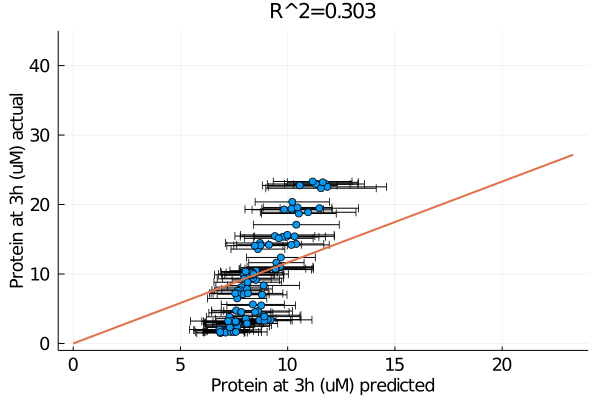

In [20]:
# Load ensemble
iter=1
ensemble_MLP = []
for idx in 1:ensemble_size
    ms = open(io -> Serialization.deserialize(io), OUTPUT*ROUND*"/model_"*string(idx)*".jls")
    push!(ensemble_MLP,ms)
end
# Predict using ensemble 
pl = plotpreds(ensemble_MLP,x_data,y_data,0)
savefig(OUTPUT*ROUND*".pdf")
pl # show plot

#### 4. Propose new compositions

In [21]:
# First generate random array (which does not repeat previously-tested compositions)
grid_size = 20000 # originally 10000
ALarray = generate_random_grid(x_data,grid_size,NCOMPS,ALLOWEDCONCS); # takes long time for large grids

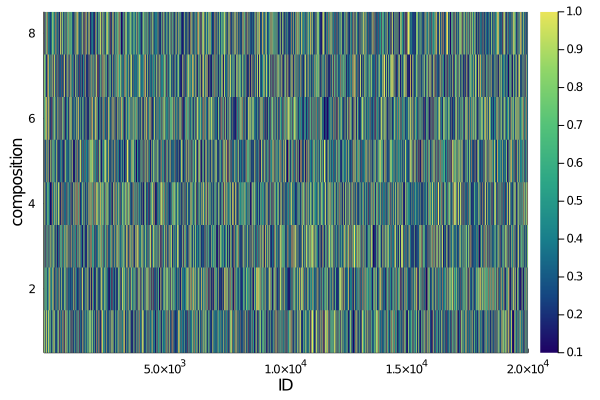

In [24]:
# Have a look at the new random array
pl = heatmap(ALarray, c=:bluegreenyellow,yaxis="composition",axis="ID")
savefig(OUTPUT*"randomarray.pdf")
pl # show plot

In [ ]:
# Use our MLP to predict output for every composition in new array
means,stdevs = ensemblepreds(ensemble_MLP,ALarray);

In [26]:
# Now choose best compositions according to our metric
exploitation = 1
exploration = 1.41
array_to_max = deepcopy(exploitation*means + exploration*stdevs); # deepcopy so original array unchanged

In [27]:
# Rank order our compositions based on exploration, exploitation, or a balance of the two

# Maximum exploitation
number_of_proposals = 99
conditions_list_exploit = []
for count = 1:number_of_proposals
    indmax = argmax(means)[1]
    push!(conditions_list_exploit,indmax)
    means[indmax] = -1
end

# Maximum exploration
conditions_list_explore = []
for count = 1:number_of_proposals
    indmax = argmax(stdevs)[1]
    push!(conditions_list_explore,indmax)
    stdevs[indmax] = -1
end

# Balanced exploration/exploitation
conditions_list_balance = []
for count = 1:number_of_proposals
    indmax = argmax(array_to_max)[1]
    push!(conditions_list_balance,indmax)
    array_to_max[indmax] = -1
end

In [ ]:
# show best exploitation
ALarray_exploit = ALarray[:,conditions_list_exploit];
a,b = ensemblepreds(ensemble_MLP,ALarray_exploit);
plot(a,yerror=b)
savefig(OUTPUT*ROUND*"_exploit_preds.pdf")

# show best exploration
ALarray_explore = ALarray[:,conditions_list_explore];
c,d = ensemblepreds(ensemble_MLP,ALarray_explore);
plot(c,yerror=d)
savefig(OUTPUT*ROUND*"_explore_preds.pdf")

# show best balance 
ALarray_balance = ALarray[:,conditions_list_balance];
e,f = ensemblepreds(ensemble_MLP,ALarray_balance);
plot(e,yerror=f)
savefig(OUTPUT*ROUND*"_balance_preds.pdf")

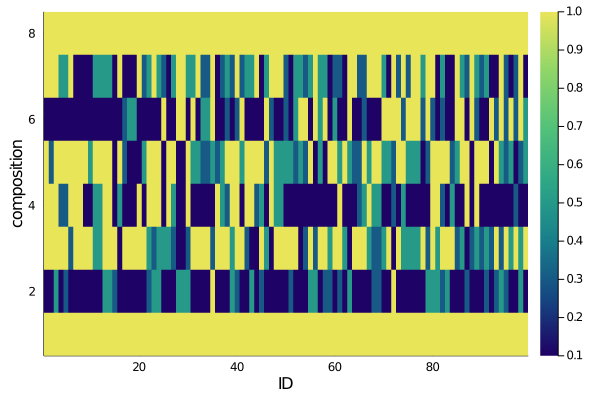

In [32]:
# Going forward, we choose the compositions that maximise the balance of 
# exploration and exploitation. Let's save these and have a look
CSV.write(INPUT*ROUND*"_proposed.csv", DataFrame(ALarray_balance)); 

pl = heatmap(ALarray_balance, c=:bluegreenyellow,yaxis="composition",axis="ID")
savefig(OUTPUT*ROUND*"_proposed.pdf")
pl # show plot

This set of compositions is used as the input for the next round of learning.